# Transform Data

Here, all of the data will be imported and transformed into a single easy-to-use file "clean_data.csv" containing monthly stock features and returns.

A subset of 1159 stocks was used over this period (rather than the full 27868 to speed up calculations). The selection used was those with full CRSP data which is done in the "GetStockList" file. Note that the final stock data used will be from January 2004 to December 2023, but due to calculations that require rolled back values, more data than needed is processed (between January 1995 and December 2024), allowing us to have a full set of parameter values for the actual testing.

In [1]:
#Load packages
suppressPackageStartupMessages({
    if(!require(tidyverse)){install.packages("tidyverse")}
    if(!require(tidyquant)){install.packages("tidyquant")}
    if(!require(lubridate)){install.packages("lubridate")}
    if(!require(dplyr)){install.packages("dplyr")}
    if(!require(PerformanceAnalytics)){install.packages("PerformanceAnalytics")}
    
    library(tidyverse)
    library(tidyquant)
    library(lubridate)
    library(dplyr)
    library(PerformanceAnalytics)
})

In [2]:
#Final dates we will filter by
start_date = "2004-1-1"
end_date = "2023-12-31"

### CRSP Data

First, import our monthly CRSP data for stocks in our stock list, and clean it.

In [3]:
#Import Initial CRSP Data
init_data <- read_csv("Data/Downloaded/crsp_monthly.csv", show_col_types = FALSE)

head(init_data, 5)

PERMNO,date,TICKER,PERMCO,PRC,RET,SHROUT,sprtrn
<dbl>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10026,1995-01-31,JJSF,7976,10.7500,-0.075269,9408,0.024278
10026,1995-02-28,JJSF,7976,11.5625,0.075581,9408,0.036074
10026,1995-03-31,JJSF,7976,10.3750,-0.102703,9382,0.027329
10026,1995-04-28,JJSF,7976,11.8750,0.144578,9359,0.027960
10026,1995-05-31,JJSF,7976,12.1250,0.021053,9359,0.036312


The initial data contains basic features for stocks like their price or ticker. 

We remove any duplicate entries and rename/reorder our columns.

In [4]:
#Clean data structure
cols_to_use <- c("date", "PERMNO", "PERMCO", "TICKER", "PRC", "RET", "SHROUT")
col_names <- c("DATE","PERMNO","PERMCO","TIC","PRC","RET","SHROUT")

crsp_data <- init_data[cols_to_use] %>%             #Select columns
    setNames(col_names) %>%                         #Set column names
    mutate(DATE = lubridate::rollforward(DATE)) %>% #Set dates to EOM
    distinct()                                      #Remove duplicates

head(crsp_data, 3)

DATE,PERMNO,PERMCO,TIC,PRC,RET,SHROUT
<date>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1995-01-31,10026,7976,JJSF,10.7500,-0.075269,9408
1995-02-28,10026,7976,JJSF,11.5625,0.075581,9408
1995-03-31,10026,7976,JJSF,10.3750,-0.102703,9382


### CRSP Daily

Here, we import and transform daily CRSP stock data for our stock list. We need the stock volatility based on daily data. Note that since doing rolling calculations on this much data takes ~10 minutes, the output is stored in a CSV as an intermediary step allowing for easy retrieval on re-running. If "generate_data" is TRUE, then the data file will be generated from scratch.

In [5]:
#Import Initial CRSP daily data
init_daily <- read_csv("Data/Downloaded/crsp_daily.csv", show_col_types = FALSE)
generate_data = FALSE #Set to TRUE to re-generate volatility data file

head(init_daily, 3)

PERMNO,date,RET
<dbl>,<date>,<dbl>
10026,1995-01-03,-0.010753
10026,1995-01-04,0.000000
10026,1995-01-05,-0.010870


Now, we compute The annual stock volatility (with 252 trading days) following the method used in "Momentum and the Cross-section of Stock Volatility" by Fan et al. (2022).

In [6]:
#Compute stock volatility for each month
if (generate_data) {
cols_to_use <- c("PERMNO", "date", "RET")
col_names <- c("PERMNO","DATE","RET")

daily_vol <- init_daily[cols_to_use] %>%     #Select columns
    setNames(col_names)   %>%                #Set column names
    drop_na() %>%                            #Remove NA values
    filter(RET != "C") %>%                   #Remove values where return is unavailable
    mutate(RET = as.numeric(RET)) %>%        #Convert returns to number
    group_by(PERMNO) %>%
    mutate(SRET = RET ^ 2) %>%               #Calculate sum of squares of returns
    mutate(SSROLL = rollsumr(x = SRET, 252, fill = NA)) %>% #Calculate rolling sum of returns
    ungroup() %>%
    mutate(VOL = sqrt(21 / 252 * SSROLL)) %>%        #Compute volatility
    select(all_of(c("DATE", "PERMNO", "VOL"))) %>%   #Select needed columns
    filter(DATE >= "1997-1-1")                       #Only keep data with a full rolling period

head(daily_vol, 3)
}

We computed the rolling returns for every daily entry. We only care about the data available at the end of each month for our final monthly dataset, so we only need to keep the last volatility metric available each month.

In [7]:
#Select the last volatility in each month, and save as CSV
if (generate_data) {
vol_formatted <- daily_vol %>% 
    group_by(PERMNO, month = lubridate::ceiling_date(DATE, "month")) %>%
    slice_tail() %>%                                #Keep only last entry of month
    ungroup() %>%
    mutate(DATE = lubridate::rollforward(DATE)) %>% #Set dates to EOM
    select(-all_of("month"))                        
    
    head(vol_formatted, 3)
}

Save data as CSV file to be imported quickly.

In [8]:
#Save as CSV
if (generate_data) {
    write.csv(vol_formatted, "Data/Generated/stock_vol.csv", row.names = FALSE)
}

Read in data from CSV.

In [9]:
#Read in stored data
stock_vol <- read_csv("Data/Generated/stock_vol.csv", show_col_types = FALSE)

tail(stock_vol, 3)

DATE,PERMNO,VOL
<date>,<dbl>,<dbl>
2024-10-31,92807,0.1408991
2024-11-30,92807,0.1437990
2024-12-31,92807,0.1431803


### CRSP & Compustat Data

Now, we pull additional stock feature data from the merged CRSP and Compustat Fundamentals Annual WRDS database. This allows us to use Compustat features using the common identifier PERMNO. Note that this data is quarterly, and so we will need to remedy this later.

In [10]:
#Import Initial CRSP Data
init_feat <- read_csv("Data/Downloaded/crsp_comp.csv", show_col_types = FALSE)

head(init_feat, 3)

PERMNO,MthCalDt,UGVKEY,datadate,indfmt,consol,popsrc,datafmt,curcd,ceq,costat
<dbl>,<date>,<chr>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
10026,1995-01-31,012825,1994-09-30,INDL,C,D,STD,USD,100.545,A
10026,1995-02-28,012825,1994-09-30,INDL,C,D,STD,USD,100.545,A
10026,1995-03-31,012825,1994-09-30,INDL,C,D,STD,USD,100.545,A


We will only select the needed variables which is the book value of the firm (ceqq). N

In [11]:
#Format data
cols_to_use <- c("PERMNO", "MthCalDt", "ceq")
col_names <- c("PERMNO","DATE","CEQ")

feat_data <- init_feat[cols_to_use] %>%             #Select columns
    setNames(col_names) %>%                         #Set column names
    mutate(DATE = lubridate::rollforward(DATE)) %>% #Roll forward date
    distinct()                                      #Remove duplicates

head(feat_data,3)

PERMNO,DATE,CEQ
<dbl>,<date>,<dbl>
10026,1995-01-31,100.545
10026,1995-02-28,100.545
10026,1995-03-31,100.545


### Fama-French Monthly Data

Here we import and transform the Fama-French 5-factor data to get the performance of Fama-French portfolios, along with market and risk free returns.

In [12]:
#Import Feature Data
init_ff <- read_csv("Data/Downloaded/ff_monthly.csv", show_col_types = FALSE)

head(init_ff, 3)

mktrf,smb,hml,rmw,cma,rf,umd,dateff
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
0.0180,-0.0306,0.0257,0.0017,-0.0075,0.0042,-0.0181,1995-01-31
0.0363,-0.0054,0.0108,0.0059,-0.0033,0.0040,-0.0039,1995-02-28
0.0219,-0.0051,-0.0215,-0.0017,0.0022,0.0046,0.0043,1995-03-31


In [13]:
#Format data
cols_to_use <- c("dateff", "mktrf", "rf", "umd")
col_names <- c("DATE","XRM", "RF", "WML")
ff_data <- init_ff[cols_to_use] %>%                 #Select columns
    setNames(col_names) %>%                         #Set column names
    mutate(DATE = lubridate::rollforward(DATE)) %>% #Set dates to EOM
    distinct()                                      #Remove duplicates
head(ff_data,3)

DATE,XRM,RF,WML
<date>,<dbl>,<dbl>,<dbl>
1995-01-31,0.0180,0.0042,-0.0181
1995-02-28,0.0363,0.0040,-0.0039
1995-03-31,0.0219,0.0046,0.0043


### Fama-French Daily Data

Use the Fama-French daily data to calculate the volatility of the WML portfolio.

In [14]:
#Import Feature Data
init_ffd <- read_csv("Data/Downloaded/ff_daily.csv", show_col_types = FALSE)

head(init_ffd, 3)

date,rf,umd
<date>,<dbl>,<dbl>
1995-01-03,2e-04,-0.0117
1995-01-04,2e-04,-0.0056
1995-01-05,2e-04,-0.0039


We format the data and compute the variance forcast which is the rolling sum of squares of momentum returns over the past 126 days.

In [15]:
#Format data and compute variance forcast
cols_to_use <- c("date", "umd")
col_names <- c("DATE", "WML")

ffd_data <- init_ffd[cols_to_use] %>%                       #Select columns
    setNames(col_names) %>%                                 #Set column names
    drop_na() %>%                                           #Remove NA values
    mutate(SRET = WML ^ 2) %>%                              #Calculate sum of squares of returns
    mutate(SSROLL = rollsumr(x = SRET, 126, fill = NA)) %>% #Calculate rolling sum of returns
    mutate(WML_VOL = sqrt(21 / 126 * SSROLL)) %>%           #Compute volatility
    select(all_of(c("DATE", "WML_VOL"))) %>%                #Select needed columns
    filter(DATE >= "1997-1-1")                              #Only keep data with a full rolling period

head(ffd_data,3)

DATE,WML_VOL
<date>,<dbl>
1997-01-02,0.01715202
1997-01-03,0.01703839
1997-01-06,0.01703839


Again, we computed the rolling returns for every daily entry. We only care about the data available at the end of each month for our final monthly dataset, so we only need to keep the last volatility metric available for each month.

In [16]:
#Select monthly returns
WML_VOL_data <- ffd_data %>% 
    group_by(month = lubridate::ceiling_date(DATE, "month")) %>%
    slice_tail() %>%                                #Keep only last entry of month
    ungroup() %>%
    mutate(DATE = lubridate::rollforward(DATE)) %>% #Set dates to EOM
    select(all_of(c("DATE", "WML_VOL")))

head(WML_VOL_data, 3)

DATE,WML_VOL
<date>,<dbl>
1997-01-31,0.01584787
1997-02-28,0.01713072
1997-03-31,0.01762276


### Create Combined Dataset

Now that all of our datasets are in the same format, we can combine them all into a single monthly dataset.

In [17]:
#Merge datasets together
comb_data <- left_join(crsp_data, feat_data, by = c("PERMNO", "DATE")) %>%
    left_join(stock_vol, by = c("PERMNO", "DATE")) %>%
    left_join(ff_data, by = c("DATE")) %>%
    left_join(WML_VOL_data, by = c("DATE")) %>%
    arrange(PERMNO, DATE)                   #Order data 

head(filter(comb_data, DATE > start_date), 5)

DATE,PERMNO,PERMCO,TIC,PRC,RET,SHROUT,CEQ,VOL,XRM,RF,WML,WML_VOL
<date>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2004-01-31,10026,7976,JJSF,42.10,0.114936,8801,182.564,0.09347483,0.0215,7e-04,0.0258,0.02589047
2004-02-29,10026,7976,JJSF,47.26,0.122565,8801,182.564,0.09796190,0.0140,6e-04,-0.0114,0.02849751
2004-03-31,10026,7976,JJSF,45.18,-0.044012,8906,182.564,0.10015411,-0.0132,9e-04,0.0017,0.02949613
2004-04-30,10026,7976,JJSF,37.71,-0.165339,8911,182.564,0.10577529,-0.0183,8e-04,-0.0538,0.02896038
2004-05-31,10026,7976,JJSF,39.53,0.048263,8911,182.564,0.10950843,0.0117,6e-04,0.0150,0.02831440


Next, use calculations to add key features like return (RET), or book-to-market ratio (BMKT).

Our momentum proxy is the past 12 month return (minus the most recent month). This is used to protect against short term reversals.

In [18]:
#Add features
fact_data <- comb_data %>% group_by(PERMNO) %>%
    mutate(XRET = RET - RF) %>%                     #Add excess return
    mutate(FRET = lead(RET)) %>%                    #Add future returns
    mutate(MCAP = SHROUT * PRC) %>%                 #Add market capitalization
    mutate(BMKT = CEQ / MCAP) %>%                   #Add book-to-market ratio
    mutate(RET11 = 1/11 * 
           (rollsumr(x = RET, 12, fill = NA) - RET)) %>%    #Rolling momentum
    mutate(XRET11 = 1/11 * 
           (rollsumr(x = XRET, 12, fill = NA) - XRET)) %>%  #Rolling excess momentum
    mutate(RV = XRET11 / (VOL ^ 2)) %>%             #RV ratio         
    ungroup()

head(filter(fact_data, DATE > start_date), 3)

DATE,PERMNO,PERMCO,TIC,PRC,RET,SHROUT,CEQ,VOL,XRM,RF,WML,WML_VOL,XRET,FRET,MCAP,BMKT,RET11,XRET11,RV
<date>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2004-01-31,10026,7976,JJSF,42.10,0.114936,8801,182.564,0.09347483,0.0215,7e-04,0.0258,0.02589047,0.114236,0.122565,370522.1,0.0004927209,0.03309673,0.03226036,3.692154
2004-02-29,10026,7976,JJSF,47.26,0.122565,8801,182.564,0.09796190,0.0140,6e-04,-0.0114,0.02849751,0.121965,-0.044012,415935.3,0.0004389241,0.03532145,0.03450327,3.595389
2004-03-31,10026,7976,JJSF,45.18,-0.044012,8906,182.564,0.10015411,-0.0132,9e-04,0.0017,0.02949613,-0.044912,-0.165339,402373.1,0.0004537182,0.04209582,0.04131400,4.118695


### Add WML* factor

Compute WML* returns. This strategy scales the portfolio size based on an annualized target volatility of 12%. This factor is suggested by Barroso and Santa-Clara (2015).

In [19]:
target_vol <- 0.12 / sqrt(12) #Bring to monthly volatility

fact_data2 <- fact_data %>% 
    mutate(WML_star = target_vol / WML_VOL * WML) #Compute WML*

head(filter(fact_data2, DATE > start_date), 3)

DATE,PERMNO,PERMCO,TIC,PRC,RET,SHROUT,CEQ,VOL,XRM,⋯,WML,WML_VOL,XRET,FRET,MCAP,BMKT,RET11,XRET11,RV,WML_star
<date>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2004-01-31,10026,7976,JJSF,42.10,0.114936,8801,182.564,0.09347483,0.0215,⋯,0.0258,0.02589047,0.114236,0.122565,370522.1,0.0004927209,0.03309673,0.03226036,3.692154,0.034519963
2004-02-29,10026,7976,JJSF,47.26,0.122565,8801,182.564,0.09796190,0.0140,⋯,-0.0114,0.02849751,0.121965,-0.044012,415935.3,0.0004389241,0.03532145,0.03450327,3.595389,-0.013857615
2004-03-31,10026,7976,JJSF,45.18,-0.044012,8906,182.564,0.10015411,-0.0132,⋯,0.0017,0.02949613,-0.044912,-0.165339,402373.1,0.0004537182,0.04209582,0.04131400,4.118695,0.001996524


### Add GRJMOM factor

Compute the returns of the GRJMOM factor suggested by Fan et al. (2022). This is a modified Sharpe Ratio where the exponent of the volatility is selected each period as the one that maximizes the Sharpe Ratio of the GRJMOM portfolio using all previous data (an expanding window approach).

In [20]:
#This function calculates the monthly returns of the GRJMOM portfolio for the
# given dataset and exponent N. It returns the Sharpe ratio of this portfolio
# at each month using an expanding window approach
GRJMOM_Sharpe <-  function(data, N) {
    expand_window <- seq_along(unique(data$DATE))         #Create our expanding window
    
    ret_data <- data %>% group_by(PERMNO) %>% 
        mutate(RV = lag(XRET11) / (lag(VOL) ^ N)) %>%     #Dynamic risk variance ratio
        ungroup() %>%
        group_by(DATE) %>%
        mutate(QUANT = ntile(RV, 10)) %>%                 #Split data into deciles based on RV
        summarise(WINRET = mean(if_else(QUANT == 10, RET, NA), #Average top decile return
                                na.rm = TRUE),
                  LOSERET = mean(if_else(QUANT == 1, RET, NA), #Average bottom decile return
                                 na.rm = TRUE),
                  RF = max(RF)) %>%
        mutate(PORTRET = WINRET - LOSERET) %>%            #Compute long-short portfolio return
        mutate(XRMEAN = rollapplyr(PORTRET - RF,          #Compute rolling monthly return
                                   width = expand_window, 
                                   FUN = mean, na.rm = TRUE)) %>%
        mutate(RSD = rollapplyr(PORTRET,                  #Compute rolling monthly standard deviation
                                width = expand_window, 
                                FUN = sd, na.rm = TRUE)) %>%
        mutate(RSHARPE = XRMEAN / RSD) %>%                #Compute rolling monthly Sharpe Ratio
        select(all_of(c("DATE", "RSHARPE")))              #Select return variables
        
    return (ret_data)
}

In [21]:
#Test the function
sub_data <- fact_data %>%
    select(all_of(c("DATE", "PERMNO", "XRET11", "RET", "VOL", "RF"))) %>%
    filter(DATE >= "2000-1-1")
test <- GRJMOM_Sharpe(sub_data, 0)
tail(test, 2)

DATE,RSHARPE
<date>,<dbl>
2024-11-30,-0.04657986
2024-12-31,-0.04753981


We compute the optimal N for each month by simply createing a portfolio based on each value of N between 0 and 4 (with intervals of 0.1) as per Fan et al. (2022). Then, the Sharpe ratios of these portfolios are compared at each period, and the best performing one is selected.

In [22]:
#Compute the best N based on our function
possible_N <- seq(0, 4, 0.1) #Constraints given by article

#Create subset of data with the appropriate period and variables
sub_data <- fact_data %>% 
    select(all_of(c("DATE", "PERMNO", "XRET11", "RET", "VOL", "RF"))) %>%
    filter(DATE >= "1999-1-1")

#Initialize a data frame storing the best N seen so far, along with its
# corresponding Sharpe Ratio
first_N <- head(possible_N, 1)
best_N <- GRJMOM_Sharpe(sub_data, first_N) %>%
    setNames(c("DATE", "BESTRSHARPE")) %>%
    mutate(N = first_N)

#We iterate through all possible values of N and keep the best one for
# each month
for (n in possible_N){
    new_Sharpe <- GRJMOM_Sharpe(sub_data, n) #Compute rolling sharpe with N

    best_N <- left_join(best_N, new_Sharpe, by = "DATE") %>%       
        mutate(N = if_else(BESTRSHARPE >=  RSHARPE, N, n)) %>% #Select best N
        mutate(RSHARPE = max(BESTRSHARPE, RSHARPE)) %>%        #Select best Sharpe
        select(all_of(c("DATE", "BESTRSHARPE", "N")))          #Select return columns
}

best_N <- select(best_N, all_of(c("DATE", "N")))

Now, we can see how the optimal N changes over time.

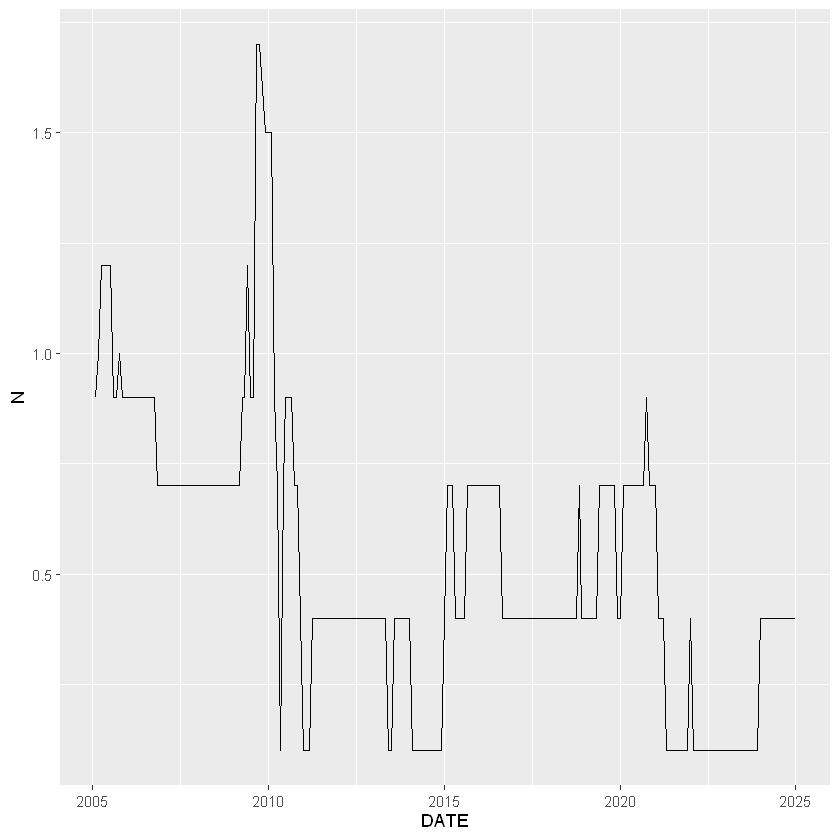

In [23]:
#Graph N
display_data <- filter(best_N, DATE > "2005-1-1")
ggplot(display_data, aes(x = DATE)) + 
    geom_line(aes(y = N))

We get very different results from the original paper, getting a value of N that stays below 1, meaning that our volatility is penalised even less than the Sharpe Ratio over the period. Since these values are computed based on an expanding window approach, we do not include the ~70 earlier years of data that were inlcuded in that paper which likely had different stock behavior. Having the 2008 financial crisis composing a large portion of our period likely had a significant impact as high-volatility stocks overperformed in its recovery, making a portfolio with less variance penalisation optimal. Another alternative explanation may be the the subset of stocks selected that may exhibit characteristics different from the market as a whole.

Next, using these optimal N values, we can compute the GRJMOM factor for each month.

In [24]:
#Compute GRJMOM
fact_data3 <- fact_data2 %>% left_join(best_N, by = "DATE") %>%
    mutate(GRJMOM = XRET11 / (VOL ^ N))

head(filter(fact_data3, DATE >= start_date), 3)

DATE,PERMNO,PERMCO,TIC,PRC,RET,SHROUT,CEQ,VOL,XRM,⋯,XRET,FRET,MCAP,BMKT,RET11,XRET11,RV,WML_star,N,GRJMOM
<date>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2004-01-31,10026,7976,JJSF,42.10,0.114936,8801,182.564,0.09347483,0.0215,⋯,0.114236,0.122565,370522.1,0.0004927209,0.03309673,0.03226036,3.692154,0.034519963,0.9,0.2722977
2004-02-29,10026,7976,JJSF,47.26,0.122565,8801,182.564,0.09796190,0.0140,⋯,0.121965,-0.044012,415935.3,0.0004389241,0.03532145,0.03450327,3.595389,-0.013857615,0.9,0.2791958
2004-03-31,10026,7976,JJSF,45.18,-0.044012,8906,182.564,0.10015411,-0.0132,⋯,-0.044912,-0.165339,402373.1,0.0004537182,0.04209582,0.04131400,4.118695,0.001996524,0.9,0.3277143


### Select Used Data

Now that all of our factors are added, we select data from the correct period and remove any rows with NA data.

In [25]:
#Select correct period
all_data <- fact_data3 %>% filter(DATE >= start_date, DATE <= end_date) %>%
    drop_na()

### Normalize Data

Finally, we need to normalize our factors to improve machine learning performance. First, examine what the initial distribution of our factors is.

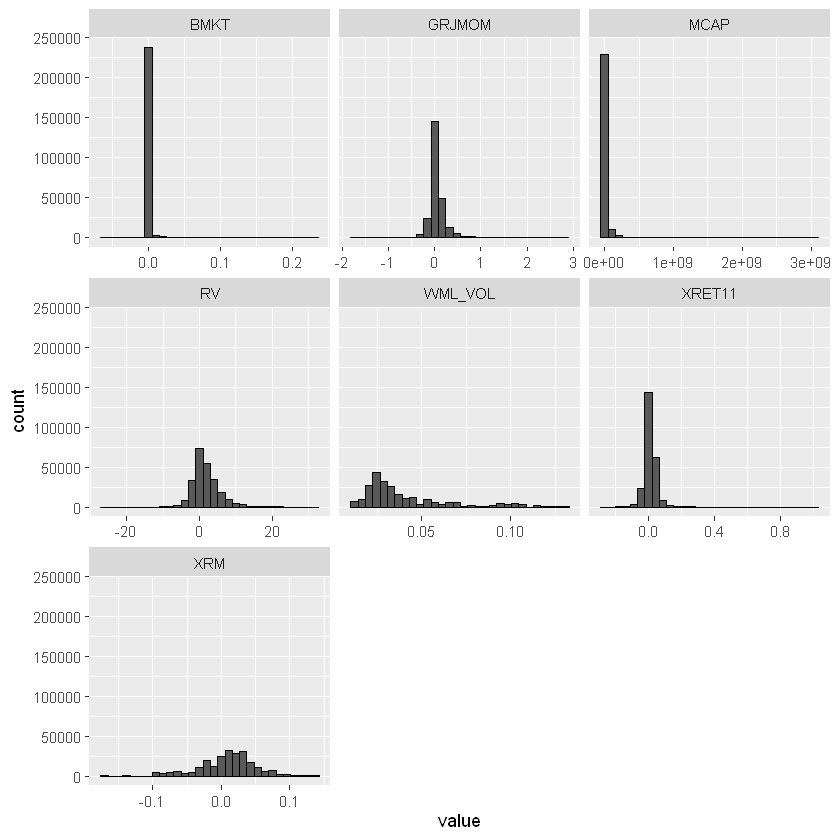

In [26]:
#Plot Distribution
factors <- c("XRM", "XRET11", "BMKT", "MCAP", "GRJMOM", "WML_VOL", "RV")

all_data %>% select(all_of(factors)) %>% 
    pivot_longer(everything(), names_to = "name", values_to = "value") %>%
    ggplot(aes(value)) + geom_histogram(bins = 30, , color = "black") +
    facet_wrap(~name, scales = "free_x")

We can see that the distributions of our predictive variables are not uniform, generally with extreme tail values, particularily for market capitalization. ECDF normalization will be used since some of the outliers are too large for Z-score standardization (like MCAP). This will introduce information loss, but should reduce the impact of oversized values, improving machine learning accuracy. Note that values are normalized at each time step (month).

XRM and WML_VOL will not be normalized since these only have one value each period, and don't have the problem of extreme magnitude values.

In [27]:
#Set of factors to be normalized
norm_factors <- c("XRET11", "BMKT", "MCAP", "GRJMOM", "RV")

#Compute ECDF normalization at each month
norm_data <- all_data %>% group_by(DATE) %>%
    mutate_at(norm_factors, ~ecdf(.)(.)) %>%
    ungroup()
head(norm_data, 3)

DATE,PERMNO,PERMCO,TIC,PRC,RET,SHROUT,CEQ,VOL,XRM,⋯,XRET,FRET,MCAP,BMKT,RET11,XRET11,RV,WML_star,N,GRJMOM
<date>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2004-01-31,10026,7976,JJSF,42.10,0.114936,8801,182.564,0.09347483,0.0215,⋯,0.114236,0.122565,0.2973503,0.5750736,0.03309673,0.4818449,0.4317959,0.034519963,0.9,0.3954858
2004-02-29,10026,7976,JJSF,47.26,0.122565,8801,182.564,0.09796190,0.0140,⋯,0.121965,-0.044012,0.3209028,0.4936212,0.03532145,0.4563297,0.3444553,-0.013857615,0.9,0.3316977
2004-03-31,10026,7976,JJSF,45.18,-0.044012,8906,182.564,0.10015411,-0.0132,⋯,-0.044912,-0.165339,0.3107843,0.5392157,0.04209582,0.5401961,0.3911765,0.001996524,0.9,0.4039216


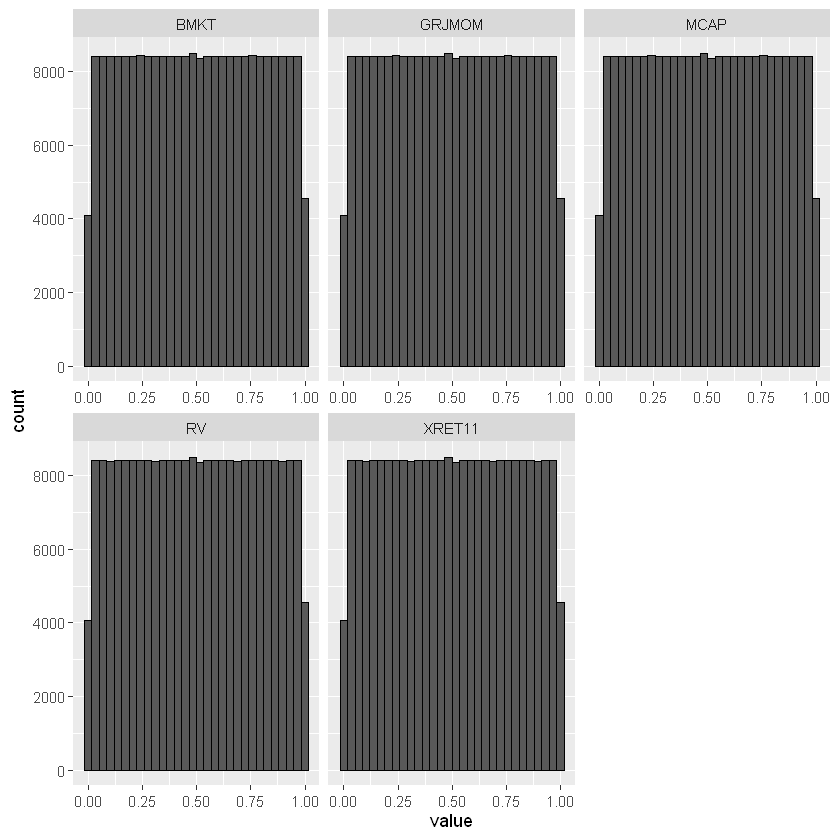

In [28]:
#Plot Normalized Distribution
norm_data %>% select(all_of(norm_factors)) %>% 
    pivot_longer(everything(), names_to = "name", values_to = "value") %>%
    ggplot(aes(value)) + geom_histogram(bins = 30, , color = "black") +
    facet_wrap(~name, scales = "free_x")

Our normalization is effective, and the features are now standardized.

### Save Our Clean ML Data

Now that the data transformation and cleaning step is done, the final data file is saved as "clean_data.csv" where it can be used for machine learning.

In [29]:
write.csv(norm_data, "Data/Generated/clean_data.csv", row.names = FALSE)